In [1]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2

In [2]:
include("../../../util2.j")

colnorm (generic function with 1 method)

In [5]:
@load "../data/sim2data.jld";

In [6]:
# priors #
ϕU = 300 / sqrt(2); ϕL = 3 / sqrt(2);

In [7]:
x_1 = X_ord[S1_ind, :]; x_2 = X_ord[S2_ind, :]; 
y_1 = Y_ord[S1_ind, 1]; y_2 = Y_ord[S2_ind, 2]; 
coords_1 = coords_ord[S1_ind, :]; coords_2 = coords_ord[S2_ind, :]; 
P1_ind = setdiff(1:N, S1_ind);
P2_ind = setdiff(1:N, S2_ind);
coords_ord_P1 = coords_ord[P1_ind, :];
coords_ord_P2 = coords_ord[P2_ind, :];

In [8]:
using RCall
@rput x_1 x_2 y_1 y_2 X_ord;
@rput q p K;
@rput ϕU ϕL;
@rput coords_1 coords_2 coords_ord_P1 coords_ord_P2 P1_ind P2_ind


R"""
library(spBayes)
set.seed(1)
n.samples <- 20000
A.starting <- diag(1, q)[lower.tri(diag(1,q), TRUE)]
starting <- list("phi"=rep(3/0.5,q), "A"=A.starting, "Psi"=rep(1,q))
tuning <- list("phi"=rep(0.1,q), "A"=rep(0.01,length(A.starting)), "Psi"=rep(0.01,q))
priors <- list("beta.Flat", "phi.Unif"=list(rep(ϕL, q), rep(ϕU, q)),
               "K.IW"=list(q + 1, diag(1.0, q)), "Psi.ig"=list(rep(2 , q), rep(0.5, q)))
t <- proc.time()
m.1 <- spMisalignLM(list(y_1~x_1-1, y_2~x_2-1), 
                    coords = list(coords_1, coords_2), starting=starting, tuning=tuning, priors=priors,
                    n.samples=n.samples, cov.model="exponential", n.report=100)
burn.in <- 0.75*n.samples

m.1 <- spRecover(m.1, start = burn.in)

print(proc.time()-t)

print(round(summary(m.1$p.theta.recover.samples)$quantiles[,c(3,1,5)],2))
print(round(summary(m.1$p.beta.recover.samples)$quantiles[,c(3,1,5)],2))
theta_samples_all <- m.1$p.theta.samples
theta_samples <- m.1$p.theta.recover.samples
beta_samples <- m.1$p.beta.recover.samples
w_samples <- m.1$p.w.recover.samples
cat(m.1$run.time)

t <- proc.time()
# predict for all locations, i.e., observed and not observed
out <- spPredict(m.1, start = burn.in, thin = 1, pred.covars = list(X_ord[P1_ind, ], X_ord[P2_ind, ]),
                pred.coords = list(coords_ord_P1, coords_ord_P2))
cat("\n", proc.time() - t)
mean_quants <- function(x){c(mean(x), quantile(x, prob=c(0.5, 0.025, 0.975)))}
yhat <- apply(out$p.y.predictive.samples, 1, mean_quants)
m1_w_hat <- summary(mcmc(t(m.1$p.w.recover.samples)))$quantiles[,c(3,1,5)]


# size for the mapping of w               
width <- 360*3
height <- 360*3
pointsize <- 16

png(paste("../../pics/MCMC_sim4_spBayes.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
plot(m.1$p.theta.samples)
dev.off()

"""
@rget theta_samples_all
@rget theta_samples
@rget beta_samples
@rget yhat
@rget m1_w_hat
@rget w_samples

┌ Warning: Package RCall does not have AxisArrays in its dependencies:
│ - If you have RCall checked out for development and have
│   added AxisArrays as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with RCall
│ Loading AxisArrays into RCall from project dependency, future warnings for RCall are suppressed.
└ @ nothing nothing:840
┌ Warning: RCall.jl: Loading required package: coda
│ Loading required package: magic
│ Loading required package: abind
│ Loading required package: Formula
│ Loading required package: Matrix
└ @ RCall /home/lu/.julia/packages/RCall/ffM0W/src/io.jl:113


----------------------------------------
	General model description
----------------------------------------
Model fit with 2 outcome variables.

Number of observations within each outcome: 1000 1000 

Number of covariates for each outcome (including intercept if specified): 2 2 

Total number of observations: 2000

Total number of covariates (including intercept if specified): 4

Using the exponential spatial correlation model.

Number of MCMC samples 20000.

Priors and hyperpriors:
	beta flat.

	K IW hyperpriors df=3.00000, S=
	1.000	0.000	
	0.000	1.000	

	Diag(Psi) IG hyperpriors
		parameter	shape	scale
		Psi[1,1]	2.0	0.50
		Psi[2,2]	2.0	0.50

	phi Unif hyperpriors
		parameter	a	b
		phi[1]		2.12132	212.13203
		phi[2]		2.12132	212.13203

-------------------------------------------------
		Sampling
-------------------------------------------------
Sampled: 100 of 20000, 0.50%
Report interval Metrop. Acceptance rate: 34.00%
Overall Metrop. Acceptance rate: 34.00%
----------------------

Sampled: 4500 of 20000, 22.50%
Report interval Metrop. Acceptance rate: 9.00%
Overall Metrop. Acceptance rate: 7.64%
-------------------------------------------------
Sampled: 4600 of 20000, 23.00%
Report interval Metrop. Acceptance rate: 7.00%
Overall Metrop. Acceptance rate: 7.63%
-------------------------------------------------
Sampled: 4700 of 20000, 23.50%
Report interval Metrop. Acceptance rate: 7.00%
Overall Metrop. Acceptance rate: 7.62%
-------------------------------------------------
Sampled: 4800 of 20000, 24.00%
Report interval Metrop. Acceptance rate: 8.00%
Overall Metrop. Acceptance rate: 7.62%
-------------------------------------------------
Sampled: 4900 of 20000, 24.50%
Report interval Metrop. Acceptance rate: 9.00%
Overall Metrop. Acceptance rate: 7.65%
-------------------------------------------------
Sampled: 5000 of 20000, 25.00%
Report interval Metrop. Acceptance rate: 11.00%
Overall Metrop. Acceptance rate: 7.72%
-----------------------------------------------

Sampled: 9500 of 20000, 47.50%
Report interval Metrop. Acceptance rate: 12.00%
Overall Metrop. Acceptance rate: 7.66%
-------------------------------------------------
Sampled: 9600 of 20000, 48.00%
Report interval Metrop. Acceptance rate: 11.00%
Overall Metrop. Acceptance rate: 7.70%
-------------------------------------------------
Sampled: 9700 of 20000, 48.50%
Report interval Metrop. Acceptance rate: 11.00%
Overall Metrop. Acceptance rate: 7.73%
-------------------------------------------------
Sampled: 9800 of 20000, 49.00%
Report interval Metrop. Acceptance rate: 14.00%
Overall Metrop. Acceptance rate: 7.80%
-------------------------------------------------
Sampled: 9900 of 20000, 49.50%
Report interval Metrop. Acceptance rate: 13.00%
Overall Metrop. Acceptance rate: 7.85%
-------------------------------------------------
Sampled: 10000 of 20000, 50.00%
Report interval Metrop. Acceptance rate: 6.00%
Overall Metrop. Acceptance rate: 7.83%
------------------------------------------

Sampled: 14400 of 20000, 72.00%
Report interval Metrop. Acceptance rate: 13.00%
Overall Metrop. Acceptance rate: 7.52%
-------------------------------------------------
Sampled: 14500 of 20000, 72.50%
Report interval Metrop. Acceptance rate: 12.00%
Overall Metrop. Acceptance rate: 7.55%
-------------------------------------------------
Sampled: 14600 of 20000, 73.00%
Report interval Metrop. Acceptance rate: 7.00%
Overall Metrop. Acceptance rate: 7.55%
-------------------------------------------------
Sampled: 14700 of 20000, 73.50%
Report interval Metrop. Acceptance rate: 8.00%
Overall Metrop. Acceptance rate: 7.55%
-------------------------------------------------
Sampled: 14800 of 20000, 74.00%
Report interval Metrop. Acceptance rate: 9.00%
Overall Metrop. Acceptance rate: 7.56%
-------------------------------------------------
Sampled: 14900 of 20000, 74.50%
Report interval Metrop. Acceptance rate: 5.00%
Overall Metrop. Acceptance rate: 7.54%
----------------------------------------

Sampled: 19400 of 20000, 97.00%
Report interval Metrop. Acceptance rate: 10.00%
Overall Metrop. Acceptance rate: 7.49%
-------------------------------------------------
Sampled: 19500 of 20000, 97.50%
Report interval Metrop. Acceptance rate: 9.00%
Overall Metrop. Acceptance rate: 7.50%
-------------------------------------------------
Sampled: 19600 of 20000, 98.00%
Report interval Metrop. Acceptance rate: 4.00%
Overall Metrop. Acceptance rate: 7.48%
-------------------------------------------------
Sampled: 19700 of 20000, 98.50%
Report interval Metrop. Acceptance rate: 9.00%
Overall Metrop. Acceptance rate: 7.49%
-------------------------------------------------
Sampled: 19800 of 20000, 99.00%
Report interval Metrop. Acceptance rate: 11.00%
Overall Metrop. Acceptance rate: 7.51%
-------------------------------------------------
Sampled: 19900 of 20000, 99.50%
Report interval Metrop. Acceptance rate: 9.00%
Overall Metrop. Acceptance rate: 7.51%
----------------------------------------

2000×5001 Array{Float64,2}:
  0.803382   0.300387   -0.693083   …  -0.296884   -0.302052   -0.482708  
  1.76515    2.34828     1.45782        2.78605     1.62614     1.67197   
  0.157229   0.860772   -0.18734        0.435638    0.460397    0.366532  
 -1.05881   -0.839104   -1.59776       -0.622169   -1.05337    -1.25087   
 -0.151574  -0.442941   -1.0239         0.056259   -0.846559   -1.005     
 -1.57809   -1.82523    -1.6887     …  -1.28883    -1.48401    -0.617943  
  0.826564   0.145945   -0.761575       0.0552812   0.622441    0.00210862
  0.963492   1.2094     -0.282211       1.38821     0.90213     0.860331  
  0.765987   0.925576    0.252296       1.16755     0.881168    0.91642   
  0.49103   -0.512136   -0.743324       0.378815   -0.156536   -0.532415  
  0.454704   0.129784   -0.379747   …   0.8114      0.560864    0.090152  
  0.45139   -0.225916   -0.561266       0.346798   -0.0966462   0.316758  
 -0.452711  -0.670568   -0.893175      -0.510199   -0.481445   -0.30681 

In [9]:
ω_incp_samples = Array{Float64, 2}(undef, size(w_samples));
N_sam = size(w_samples)[2]
for i in 1:N_sam
    for j in 1:q
        ω_incp_samples[(1 + (j - 1) * N1):(j * N1), i] = 
        w_samples[(1 + (j - 1) * N1):(j * N1), i] .+ beta_samples[i, 1 + (j - 1) * q]
    end
end

ω_incp_qt = Array{Float64, 3}(undef, N1, q, 3);
for j in 1:q
    for i in 1:N1
        ω_incp_qt[i, j, :] = quantile(ω_incp_samples[i + (j - 1) * N1, :], [0.025, 0.5, 0.975])
    end
end
ω_incp_mean = Array{Float64, 2}(undef, N1, q);
for j in 1:q
    for i in 1:N1
        ω_incp_mean[i, j] = mean(ω_incp_samples[i + (j - 1) * N1, :])
    end
end

In [12]:
@save "../results/LMC_misalign_spbayes.jld" theta_samples beta_samples yhat ω_incp_samples w_samples ω_incp_qt theta_samples_all

In [13]:
@save "../results/w_incp_mean_benchmark.jld" ω_incp_mean 

# MCMC Chain check

In [11]:
@load "../results/LMC_misalign_spbayes.jld"

7-element Array{Symbol,1}:
 :theta_samples    
 :beta_samples     
 :yhat             
 :ω_incp_samples   
 :w_samples        
 :ω_incp_qt        
 :theta_samples_all

In [12]:
@load "../results/w_incp_mean_benchmark.jld"

1-element Array{Symbol,1}:
 :ω_incp_mean

In [13]:
N_sam = size(w_samples)[2]
ω_qt = Array{Float64, 3}(undef, N1, q, 3);
for j in 1:q
    for i in 1:N1
        ω_qt[i, j, :] = quantile(w_samples[i + (j - 1) * N1, :], [0.025, 0.5, 0.975])
    end
end
ω_mean = Array{Float64, 2}(undef, N1, q);
for j in 1:q
    for i in 1:N1
        ω_mean[i, j] = mean(w_samples[i + (j - 1) * N1, :])
    end
end

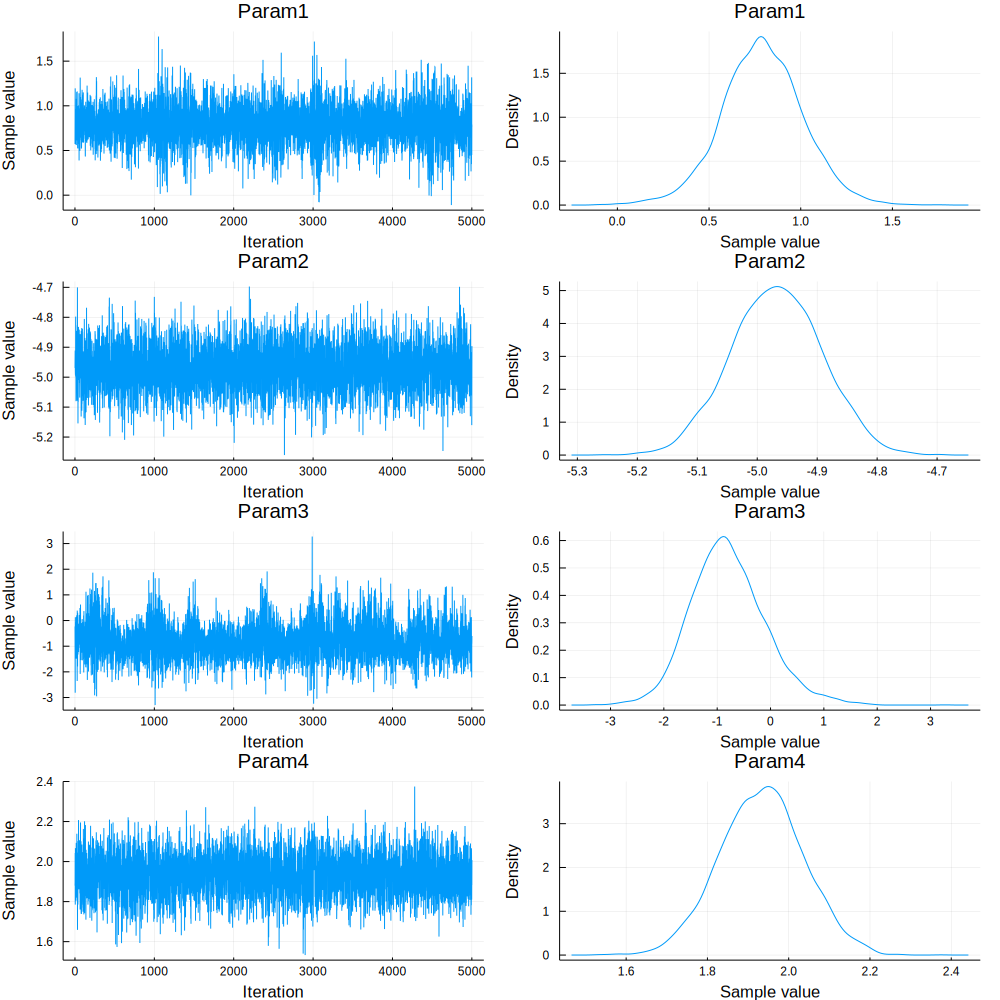

In [14]:
β_pos_sam = Array{Float64, 3}(undef, size(beta_samples)[1], p * q, 1);
β_pos_sam[:, :, 1] = hcat(beta_samples[:, 1], beta_samples[:, 2], beta_samples[:, 3], beta_samples[:, 4]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

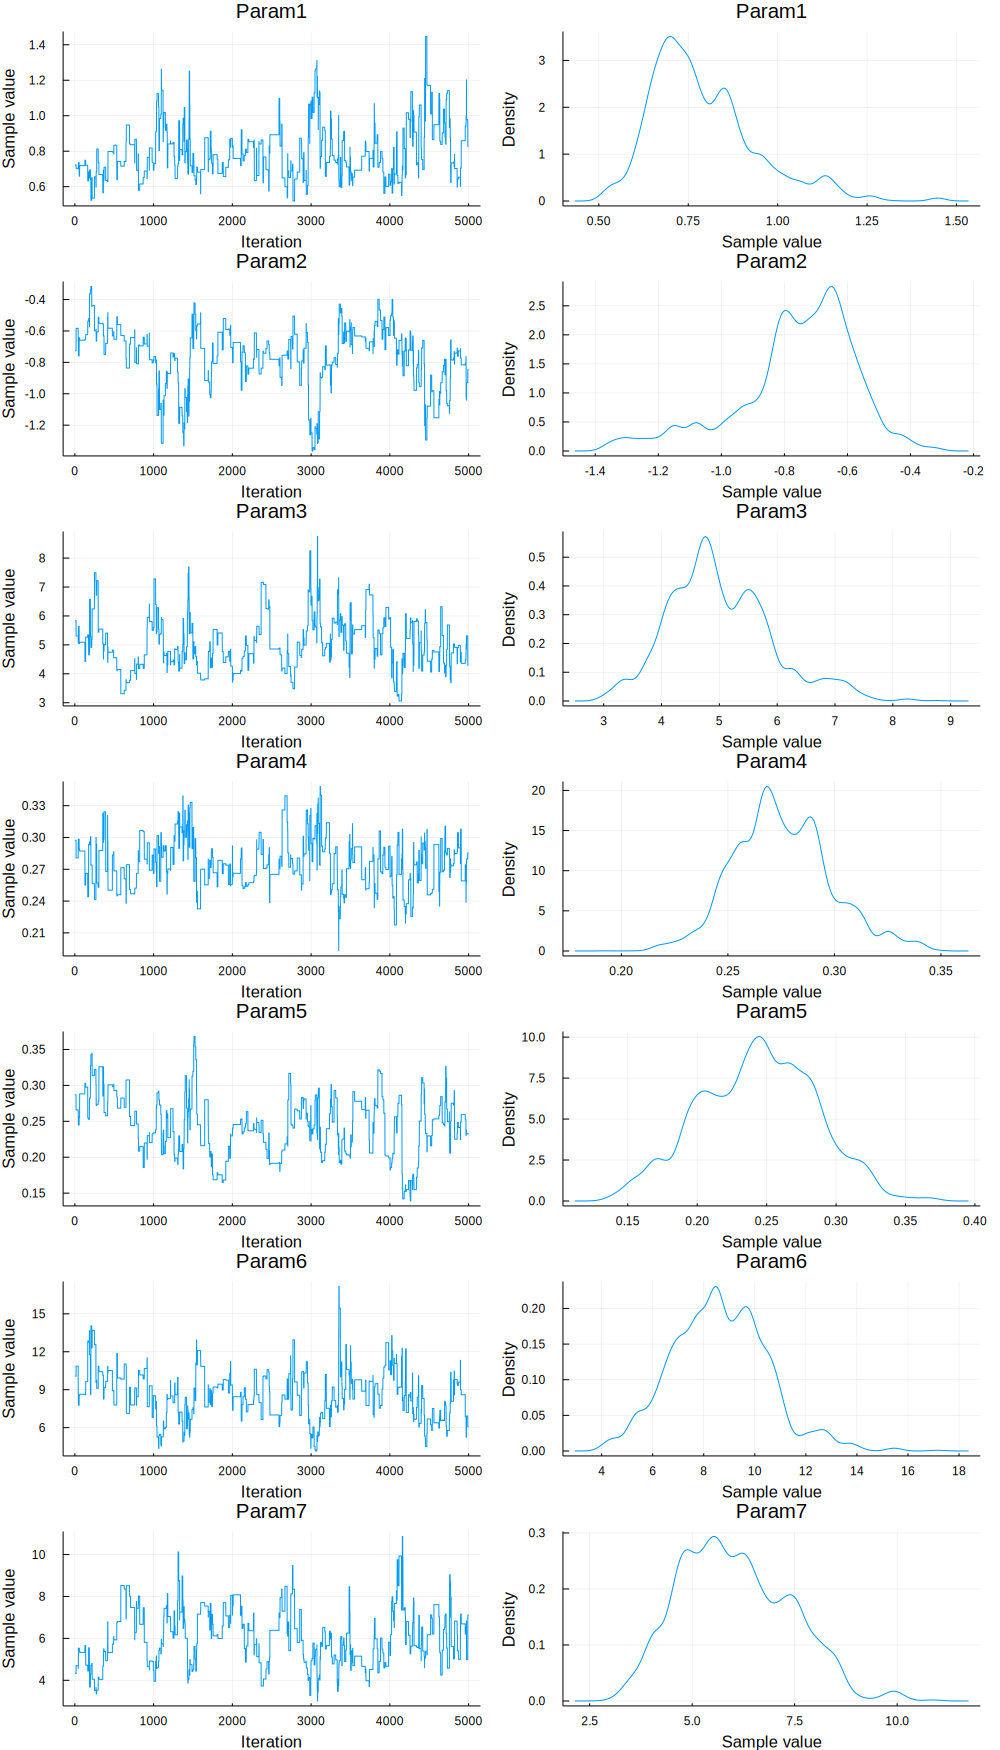

In [15]:
Λ_pos_sam = Array{Float64, 3}(undef, size(theta_samples)[1], size(theta_samples)[2], 1);
Λ_pos_sam[:, :, 1] = hcat(theta_samples[:, 1], theta_samples[:, 2], theta_samples[:, 3], theta_samples[:, 4],
    theta_samples[:, 5], theta_samples[:, 6], theta_samples[:, 7]);
Λ_chain = Chains(Λ_pos_sam);
pΛ = plot(Λ_chain)

In [16]:
Λ

2×2 Array{Float64,2}:
 1.0  -1.0
 0.0   2.0

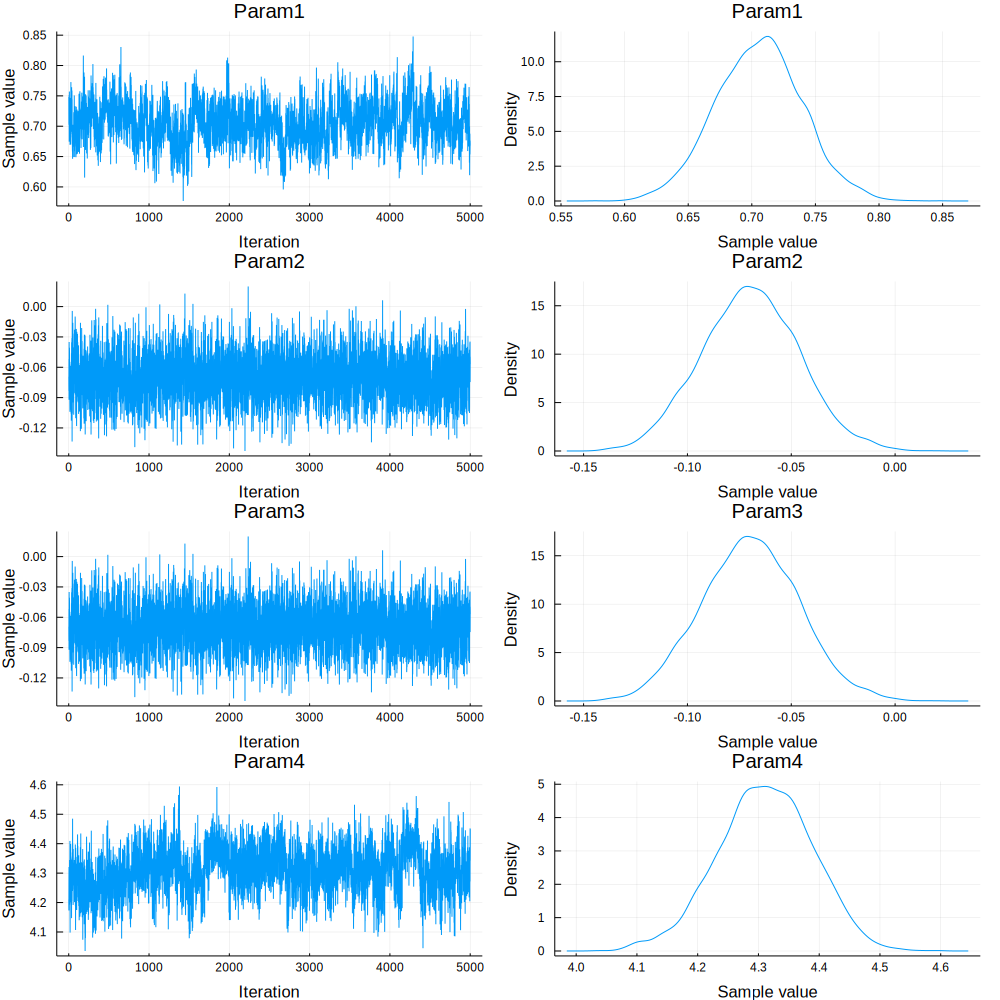

In [17]:
# check the variance covariance across latent process
N_sam = size(w_samples)[2]
cov_pos = Array{Float64, 3}(undef, q, q, N_sam);
for i in 1:N_sam
    cov_pos[:, :, i] = cov([w_samples[1:N1, i] w_samples[(1 + N1):(2 * N1), i]])
end   
# ω_incp_obs_pos_sam[:, :, i]
cov_pos_sam = Array{Float64, 3}(undef, N_sam, q * q, 1);
cov_pos_sam[:, :, 1] = hcat(cov_pos[1, 1, :], cov_pos[1, 2, :], 
    cov_pos[2, 1, :], cov_pos[2, 2, :]);
cov_pos_chain = Chains(cov_pos_sam);
pcov = plot(cov_pos_chain)

# Posterior Inference 

In [18]:
# CVG and RMSPE#
Nm = N - N1
count = fill(0.0, 2);
SPE = fill(0.0, 2)

for i in 1:Nm
    count[1] = count[1] + 
            ((yhat[3, i] < Y_ord[P1_ind[i], 1]) && 
                (yhat[4, i] > Y_ord[P1_ind[i], 1]))
    SPE[1] = SPE[1] + (yhat[1, i] - Y_ord[P1_ind[i], 1])^2
end

for i in 1:Nm
    count[2] = count[2] + 
            ((yhat[3, i + Nm] < Y_ord[P2_ind[i], 2]) && 
                (yhat[4, i + Nm] > Y_ord[P2_ind[i], 2]))
    SPE[2] = SPE[2] + (yhat[1, i + Nm] - Y_ord[P2_ind[i], 2])^2
end
print(count ./ 200);
print(sum(count) / 400);

[0.965, 0.945]0.955

In [19]:
print(round.(sqrt.(SPE ./ 200), digits = 3));
print(round(sqrt(sum(SPE) / 400), digits = 3));

[0.633, 0.918]0.788

In [20]:
# CVGL latent process#
count = fill(0.0, 2);
SPEL = fill(0.0, 2)
for j in 1:q
    for i in 1:N1
        if j == 1
            count[1] = count[1] + 
                ((ω_qt[i, j, 1 ] < ω_ord[S1_ind[i], j]) && 
                (ω_qt[i, j, 3 ] > ω_ord[S1_ind[i], j]));
            SPEL[1] = SPEL[1] + (ω_mean[i, j] - ω_ord[S1_ind[i], j])^2;
        else
            count[2] = count[2] + 
                ((ω_qt[i, j, 1] < ω_ord[S2_ind[i], j]) && 
                (ω_qt[i, j, 3] > ω_ord[S2_ind[i], j]));
            SPEL[2] = SPEL[2] + (ω_mean[i, j] - ω_ord[S2_ind[i], j])^2;
        end
    end
end
print(round.(count ./ N, digits = 3));
print(round(sum(count) / (2*N), digits = 3))

[0.793, 0.832]0.813

In [21]:
# CVGL intercept-centered latent process#
count = fill(0.0, 2);
SPEL = fill(0.0, 2)
for j in 1:q
    for i in 1:N1
        if j == 1
            count[1] = count[1] + 
                ((ω_incp_qt[i, j, 1 ] < ω_incp_obs[S1_ind[i], j]) && 
                (ω_incp_qt[i, j, 3 ] > ω_incp_obs[S1_ind[i], j]));
            SPEL[1] = SPEL[1] + (ω_incp_mean[i, j] - ω_incp_obs[S1_ind[i], j])^2;
        else
            count[2] = count[2] + 
                ((ω_incp_qt[i, j, 1] < ω_incp_obs[S2_ind[i], j]) && 
                (ω_incp_qt[i, j, 3] > ω_incp_obs[S2_ind[i], j]));
            SPEL[2] = SPEL[2] + (ω_incp_mean[i, j] - ω_incp_obs[S2_ind[i], j])^2;
        end
    end
end
print(round.(count ./ N, digits = 3));
print(round(sum(count) / (2*N), digits = 3))

[0.791, 0.816]0.803

In [22]:
# MSEL #
print(round.((SPEL ./ N1), digits = 3));
print(round((sum(SPEL) / (2 * N1)), digits = 3));

[0.111, 0.14]0.126

In [23]:
Y_P1_sam_std = (yhat[4, 1:200] .- yhat[3, 1:200]) ./ (2*1.96);
Y_P2_sam_std = (yhat[4, 201:400] .- yhat[3, 201:400]) ./ (2*1.96);

In [24]:
# CRPS #
CRPS_P1 = [(Y_P1_sam_std[i] * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[P1_ind[i], 1] - yhat[1, i]) / Y_P1_sam_std[i]) -
        ((Y_ord[P1_ind[i], 1] - yhat[1, i]) / Y_P1_sam_std[i]) * 
        (2* cdf(Normal(), (Y_ord[P1_ind[i], 1] - yhat[1, i]) / Y_P1_sam_std[i]) - 1 )))
        for i in 1:length(P1_ind)];
CRPS_P2 = [(Y_P2_sam_std[i] * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[P2_ind[i], 2] - yhat[1, i + 200]) / Y_P2_sam_std[i]) -
        ((Y_ord[P2_ind[i], 2] - yhat[1, i + 200]) / Y_P2_sam_std[i]) * 
        (2* cdf(Normal(), (Y_ord[P2_ind[i], 2] - yhat[1, i + 200]) / Y_P2_sam_std[i]) - 1 )))
        for i in 1:length(P2_ind)];

CRPS1 = sum(CRPS_P1) / length(P1_ind);
CRPS2 = sum(CRPS_P2) / length(P2_ind);
CRPS = (sum(CRPS_P1) + sum(CRPS_P2)) / (length(P1_ind) + length(P2_ind))
round.([CRPS1 CRPS2 CRPS], digits = 3)

1×3 Array{Float64,2}:
 -0.359  -0.515  -0.437

In [25]:
ω_incp_sam_std = [(ω_incp_qt[i, j, 3] - ω_incp_qt[i, j, 1]) ./ (2*1.96) 
    for i in 1:1000, j in 1:2];

In [26]:
# CRPSL over observed locations#

CRPSL_S1 = [(ω_incp_sam_std[i, 1] * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (ω_incp_obs[S1_ind[i], 1] - ω_incp_mean[i, 1]) / ω_incp_sam_std[i, 1]) -
        ((ω_incp_obs[S1_ind[i], 1] - ω_incp_mean[i, 1]) / ω_incp_sam_std[i, 1]) * 
        (2* cdf(Normal(), (ω_incp_obs[S1_ind[i], 1] - ω_incp_mean[i, 1]) / ω_incp_sam_std[i, 1]) - 1)))
        for i in 1:length(S1_ind)];

CRPSL_S2 = [(ω_incp_sam_std[i, 2] * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (ω_incp_obs[S2_ind[i], 2] - ω_incp_mean[i, 2]) / ω_incp_sam_std[i, 2]) -
        ((ω_incp_obs[S2_ind[i], 2] - ω_incp_mean[i, 2]) / ω_incp_sam_std[i, 2]) * 
        (2* cdf(Normal(), (ω_incp_obs[S2_ind[i], 2] - ω_incp_mean[i, 2]) / ω_incp_sam_std[i, 2]) - 1)))
        for i in 1:length(S2_ind)];


CRPSL1 = sum(CRPSL_S1) / length(S1_ind);
CRPSL2 = sum(CRPSL_S2) / length(S2_ind);
CRPSL = (sum(CRPSL_S1) + sum(CRPSL_S2)) / (length(S1_ind) + length(S2_ind))
round.([CRPSL1 CRPSL2 CRPSL], digits = 3)

1×3 Array{Float64,2}:
 -0.189  -0.212  -0.2

In [27]:
# INT #
INT_1 = [((2 * 1.96 * Y_P1_sam_std[i]) + 
                (2 / 0.05)*(yhat[1, i] - 1.96 * Y_P1_sam_std[i] - Y_ord[P1_ind[i], 1]) * 
                (Y_ord[P1_ind[i], 1] < (yhat[1, i] - 1.96 * Y_P1_sam_std[i])) + 
                (2 / 0.05)*(Y_ord[P1_ind[i], 1] - yhat[1, i] - 1.96 * Y_P1_sam_std[i]) * 
                (Y_ord[P1_ind[i], 1] > (yhat[1, i] + 
                1.96 * Y_P1_sam_std[i]))) for i in 1:length(P1_ind)];

INT_2 = [((2 * 1.96 * Y_P2_sam_std[i]) + 
                (2 / 0.05)*(yhat[1, i + 200] - 1.96 * Y_P2_sam_std[i] - Y_ord[P2_ind[i], 2]) * 
                (Y_ord[P2_ind[i], 2] < (yhat[1, i + 200] - 1.96 * Y_P2_sam_std[i])) + 
                (2 / 0.05)*(Y_ord[P2_ind[i], 2] - yhat[1, i + 200] - 1.96 * Y_P2_sam_std[i]) * 
                (Y_ord[P2_ind[i], 2] > (yhat[1, i + 200] + 
                1.96 * Y_P2_sam_std[i]))) for i in 1:length(P2_ind)];

INT1 = (sum(INT_1)) / (length(P1_ind));
INT2 = (sum(INT_2)) / (length(P2_ind));
INT = (sum(INT_1) + sum(INT_2))/(length(P1_ind) + (length(P2_ind)));

round.([INT1 INT2 INT], digits = 3)

1×3 Array{Float64,2}:
 2.927  4.315  3.621

In [28]:
# INTL #
INTL_1 = [((2 * 1.96 * ω_incp_sam_std[i, 1]) + 
        (2 / 0.05)*(ω_incp_mean[i, 1] - 1.96 * ω_incp_sam_std[i, 1] - 
            ω_incp_obs[S1_ind[i], 1]) * (ω_incp_obs[S1_ind[i], 1] < ( ω_incp_mean[i, 1] - 
                1.96 * ω_incp_sam_std[i, 1])) + (2 / 0.05)*(ω_incp_obs[S1_ind[i], 1] -  
            ω_incp_mean[i, 1] - 1.96 * ω_incp_sam_std[i, 1]) * 
        (ω_incp_obs[S1_ind[i], 1] > ( ω_incp_mean[i, 1] + 
                1.96 * ω_incp_sam_std[i, 1]))) for i in 1:length(S1_ind)];

INTL_2 = [((2 * 1.96 * ω_incp_sam_std[i, 2]) + 
        (2 / 0.05)*(ω_incp_mean[i, 2] - 1.96 * ω_incp_sam_std[i, 2] - 
            ω_incp_obs[S2_ind[i], 2]) * (ω_incp_obs[S2_ind[i], 2] < ( ω_incp_mean[i, 2] - 
                1.96 * ω_incp_sam_std[i, 2])) + (2 / 0.05)*(ω_incp_obs[S2_ind[i], 2] -  
            ω_incp_mean[i, 2] - 1.96 * ω_incp_sam_std[i, 2]) * 
        (ω_incp_obs[S2_ind[i], 2] > ( ω_incp_mean[i, 2] + 
                1.96 * ω_incp_sam_std[i, 2]))) for i in 1:length(S2_ind)];


INTL1 = sum(INTL_1) / length(S1_ind);
INTL2 = sum(INTL_2) / length(S2_ind);
INTL = (sum(INTL_1) + sum(INTL_2))/(length(S1_ind) + length(S2_ind));

round.([INTL1 INTL2 INTL], digits = 3)

1×3 Array{Float64,2}:
 1.535  1.728  1.631

In [29]:
covω = cov(ω_ord[S, :])

2×2 Array{Float64,2}:
  0.683048  -0.615677
 -0.615677   4.51697 

In [30]:
summary_table = Array{Float64, 2}(undef, 11, 5);
summary_table[1, :] = vcat(β[1, 1], mean(beta_samples[:, 1]),
    quantile(beta_samples[:, 1], [0.5, 0.025, 0.975]));
summary_table[2, :] = vcat(β[1, 2], mean(beta_samples[:, 3]),
    quantile(beta_samples[:, 3], [0.5, 0.025, 0.975]));
summary_table[3, :] = vcat(β[2, 1], mean(beta_samples[:, 2]),
    quantile(beta_samples[:, 2], [0.5, 0.025, 0.975]));
summary_table[4, :] = vcat(β[2, 2], mean(beta_samples[:, 4]),
    quantile(beta_samples[:, 4], [0.5, 0.025, 0.975]));
summary_table[5, :] = vcat(Σ[1, 1], mean(theta_samples[:, 4]),
    quantile(theta_samples[:, 4], [0.5, 0.025, 0.975]));
summary_table[6, :] = vcat(Σ[2, 2], mean(theta_samples[:, 5]),
    quantile(theta_samples[:, 5], [0.5, 0.025, 0.975]));
summary_table[7, :] = vcat(covω[1, 1], mean(cov_pos_sam[:, 1, 1]),
    quantile(cov_pos_sam[:, 1, 1], [0.5, 0.025, 0.975]));
summary_table[8, :] = vcat(covω[1, 2], mean(cov_pos_sam[:, 2, 1]),
    quantile(cov_pos_sam[:, 2, 1], [0.5, 0.025, 0.975]));
summary_table[9, :] = vcat(covω[2, 2], mean(cov_pos_sam[:, 4, 1]),
    quantile(cov_pos_sam[:, 4, 1], [0.5, 0.025, 0.975]));
summary_table[10, :] = vcat(ϕ1, mean(theta_samples[:, 6]),
    quantile(theta_samples[:, 6], [0.5, 0.025, 0.975]));
summary_table[11, :] = vcat(ϕ2, mean(theta_samples[:, 7]),
    quantile(theta_samples[:, 7], [0.5, 0.025, 0.975]));
summary_table = round.(summary_table; digits = 3);
rnames = ["β[1, 1]", "β[1, 2]", "β[2, 1]", "β[2, 2]", "Σ[1, 1]", "Σ[2, 2]", "cov(ω)[1, 1]", 
    "cov(ω)[1, 2]", "cov(ω)[2, 2]", "ϕ1", "ϕ2"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%"], markdown)

|              |   true |   mean | median |   2.5% |  97.5% |
|--------------|--------|--------|--------|--------|--------|
|      β[1, 1] |    1.0 |   0.79 |  0.789 |  0.344 |  1.229 |
|      β[1, 2] |   -1.0 | -0.795 | -0.841 | -2.069 |   0.74 |
|      β[2, 1] |   -5.0 | -4.968 | -4.968 | -5.115 | -4.822 |
|      β[2, 2] |    2.0 |  1.933 |  1.935 |  1.731 |  2.134 |
|      Σ[1, 1] |    0.3 |  0.275 |  0.274 |  0.233 |  0.326 |
|      Σ[2, 2] |    0.2 |  0.244 |  0.245 |  0.165 |  0.322 |
| cov(ω)[1, 1] |  0.683 |  0.706 |  0.706 |  0.639 |  0.773 |
| cov(ω)[1, 2] | -0.616 |  -0.07 |  -0.07 | -0.115 | -0.024 |
| cov(ω)[2, 2] |  4.517 |  4.311 |  4.312 |   4.15 |  4.455 |
|           ϕ1 |    6.0 |   8.63 |  8.576 |  5.251 | 12.711 |
|           ϕ2 |    6.0 |  6.045 |  5.932 |  3.731 |  8.526 |
